# Tutorial 9: Recurrent Neural Networks (RNNs) and Transfer Learning

Welcome to the ninth tutorial of the course 'Machine learning for Precision Medicine'.

In this exercise we will touch on two important topics in modern machine learning research: RNNs and transfer learning.

We have prepared a dataset for you, consisting of 4104 drug-reviews with corresponding (subjective) ratings and effectiveness scores. This dataset was derived from the **Drug Review Dataset (Druglib.com)** on the [UCI Machine Learning Repository ](https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+(Druglib.com)).

Your task will be to build a predictor that is able to predict the rating from 1 to 10. You will be free to implement a second model that predicts the effectiveness.

To build this predictor, we will first encode the reviews using sentence embedding. Every sentence of each review will be encoded as a vector of 512 numbers, using a pre-trained *universal sentence encoder* available on [TensorFlow Hub](https://tfhub.dev/google/universal-sentence-encoder/2) and published [arXiv](https://arxiv.org/abs/1803.11175). These vectors represent the content of each sentence in a dense vector. The universal sentence encoder was trained on a large corpus of text - much larger than our training set.

The model that encodes our sentences was trained with the Stanford Natural Language Inference (SNLI) corpus. The SNLI corpus is a collection of 570k human-written English sentence pairs manually labeled for balanced classification with the labels entailment, contradiction, and neutral, supporting the task of natural language inference (NLI), also known as recognizing textual entailment (RTE). Essentially, the model was trained to learn the semantic similarity between the sentence pairs.

After embedding the sentences, aach review (which will then be represented as a sequence of embeddings), will be fed into an LSTM in order to predict the rating.

The process of taking a model that was trained on a different task and using it for a new task is called transfer learning. Often the pre-trained model was trained with a lot more data than is availble for the new task. Transfer learning is usually a good idea if the number of training examples is small.


In [1]:

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from keras.layers import Input, Lambda, Dense, LSTM, RNN, GRU
from keras import Model
import keras.backend as K
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# Import the Universal Sentence Encoder's TF Hub module
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)

In [3]:
# we load the data and display a couple of reviews
drugreviews = pd.read_csv('https://raw.githubusercontent.com/remomomo/mlpm/master/data_proc.tsv', sep='\t', header=0)

for i in [0, 10, 1500, 3000]:
  print('\ndrug review example:')
  print("{}".format(drugreviews['benefitsreview'][i]))
  print('# rating: {}, effectiveness: {}'.format(drugreviews['rating'][i], drugreviews['effectiveness'][i]))


drug review example:
the antibiotic may have destroyed bacteria causing my sinus infection.  but it may also have been caused by a virus, so its hard to say.
# rating: 9, effectiveness: considerably effective

drug review example:
some pain relief recieved minimized pain when touched
# rating: 3, effectiveness: moderately effective

drug review example:
motivates, keeps me focused and helps me stay calm and alert in the same time.  not as noticeable as stimulants but more steady, no ups and downs, and it works round the clock reducing the rebound from when concerta wears off after approx 10 hours. stabilizing effect on the mood too.
# rating: 8, effectiveness: considerably effective

drug review example:
since no such infection (i.e. endocarditis) ever occured after a dental procedure, the logical conclusion is that it was successful as an antidotal/ antibacterial treatment against (i.e.) endocarditis. however, i've not been prescribed/taken it for three years, also with no post-proce

As we can see above, the reviews cover different types of drugs and have different lengths. Estimating the rating from the review is not a straight forward task and probably can't be solved perfectly. How well could you perform this? In the following cells, we will perform some additional pre-processing steps in order to split the reviews in to single sentences.

In [4]:
# we perform some additional pre-processing
reviews_split = [review.replace('i.e.','ie').replace('...','.').split('.') for review in drugreviews['benefitsreview']]
reviews_split = [ [sentence for sentence in review if len(sentence) > 8 ] for review in reviews_split ]
print("review:\n {}".format(reviews_split[3000]))
print('# length: {}'.format(len(reviews_split[3000])))

review:
 ['since no such infection (ie endocarditis) ever occured after a dental procedure, the logical conclusion is that it was successful as an antidotal/ antibacterial treatment against (ie) endocarditis', " however, i've not been prescribed/taken it for three years, also with no post-procedural infections"]
# length: 2


In [0]:
# we limit ourselves to the first 10 sentences of every review:
reviews_split = [ review[:min(10, len(review))] for review in reviews_split ]

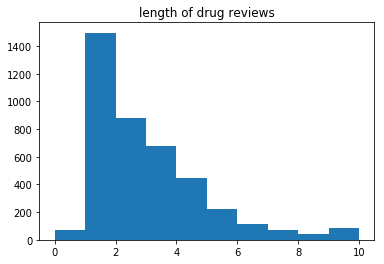

In [6]:
_ = plt.hist(np.array(list(map(len, reviews_split))), 10)
_ = plt.title('length of drug reviews')

The following cell wraps the embed-function imported above in a Keras model. We will pre-compute the embeddings for all observations using this model. Additionally, we will zero-pad the sequences to all have length (10). This will later facilitate the training process.

In [7]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
    	signature="default", as_dict=True)["default"]
  
input_text = Input(shape=(1,), dtype=tf.string)
out = Lambda(UniversalEmbedding, output_shape=(512,))(input_text)
sequence_embedder = Model(input_text, out)

W0715 20:54:35.170211 140613106571136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 20:54:35.173542 140613106571136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [8]:
all_sentences = np.concatenate(reviews_split)
print('shape before embedding and padding: {}'.format(all_sentences.shape))

shape before embedding and padding: (10501,)


In [9]:
# we pre-compute the embeddings for all the sentences:
with tf.Session() as session:

  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  
  embeddings = sequence_embedder.predict(all_sentences, verbose=1)

W0715 20:54:48.315805 140613106571136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0715 20:54:48.319411 140613106571136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0715 20:54:48.321023 140613106571136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



10501/10501 [==============================] - 4s 381us/step


Now that we have computed the embeddings for all sentences, we can visualize a couple of examples. 

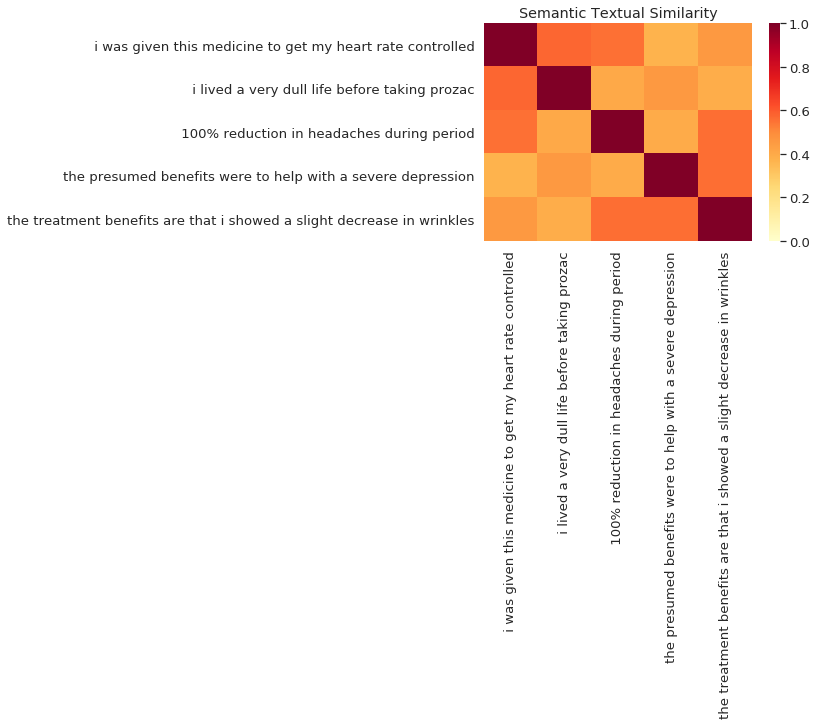

In [10]:
import seaborn as sns

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")
  
plot_similarity(all_sentences[[80,20,200,40,100]], embeddings[[80,20,200,40,100]], 90)

In [0]:
# reshaping back...
embedded_reviews = []
i = 0
for review in reviews_split:
  embedded_reviews.append(embeddings[i:(i+len(review))])
  i+=len(review)
embedded_reviews = np.array(embedded_reviews)

In [12]:
for i in [0, 10, 1500, 3000]:
  print('\ndrug review example:')
  print("{}".format(drugreviews['benefitsreview'][i]))
  print('# rating: {}, effectiveness: {}'.format(drugreviews['rating'][i], drugreviews['effectiveness'][i]))
  print('# embedding shape: {}'.format(embedded_reviews[i].shape))


drug review example:
the antibiotic may have destroyed bacteria causing my sinus infection.  but it may also have been caused by a virus, so its hard to say.
# rating: 9, effectiveness: considerably effective
# embedding shape: (2, 512)

drug review example:
some pain relief recieved minimized pain when touched
# rating: 3, effectiveness: moderately effective
# embedding shape: (1, 512)

drug review example:
motivates, keeps me focused and helps me stay calm and alert in the same time.  not as noticeable as stimulants but more steady, no ups and downs, and it works round the clock reducing the rebound from when concerta wears off after approx 10 hours. stabilizing effect on the mood too.
# rating: 8, effectiveness: considerably effective
# embedding shape: (3, 512)

drug review example:
since no such infection (i.e. endocarditis) ever occured after a dental procedure, the logical conclusion is that it was successful as an antidotal/ antibacterial treatment against (i.e.) endocarditis.

In [13]:
embedded_reviews_pad = np.array([np.pad(embedded_review, ((10-embedded_review.shape[0], 0), (0,0)), mode='constant', constant_values=0.) for embedded_review in embedded_reviews ])
print('shape after embedding and padding: {}'.format(embedded_reviews_pad.shape))

shape after embedding and padding: (4104, 10, 512)


The data has now been pre-processed and is ready to be used to train our model - a recurrant neural network:

## LSTM
RNNs are usually designed to learn patterns in sequential data, i.e. text, genomes, sensor data, ...
LSTMs (Long-shortterm memory) models are a type of RNNs to model sequential data. Sequential data follows some structure, i.e. language follows grammar rules. With a CNN only the current sample (i.e. image) is used as an input. RNN's however, also take previously seen samples as input for the feed-forward input, which adds together as two input sources, present and past data with the aim to predict new data. To feed back past data to the input, the the output of a neural network layer at time t goes back to the input of the same network layer at time t + 1. This is what is considered as memory. The sequential information is preserved in the recurrent network’s hidden state and essentially what RNNs do is sharing weights over time.

Here we will learn the sequential structure in drug reviews. 

In the lecture you heard about the different components of an LSTM, namely input gate, the forget gate and the output gate.

__Input gate:__  
First, we will squash this combined input through a tanh-activated layer resulting in values between -1 and 1. This can be expressed by:

$$ g=tanh(b^g + x_tU^g+h_{t−1}V^g),$$

where $U^g$ and $V^g$ are the weights for the input and previous cell output, respectively, and $b^g$ is the input bias. Note that the exponents g are not a raised power, but rather signify that these are the input weights and bias values.

We pass this $g$ through the input gate, which is basically a layer of sigmoid activated nodes. The idea behind these sigmoid activated nodes is to exclude elements of the input vector that are not relevant (pass the associated weights when sigmoid output of this node is close to 1, and exclude when close to 0). Then we do an element-wise multiplication of the output and the squashed input.

$$i = \sigma(b^i+x_tU^i+h_{t-i}V^i) $$  and  
$$g\cdot i$$


__Forget gate:__  
In the next step, we add the internal state variable st, which lagged one time step i.e. st−1, to the input data and pass it through the forget gate. This is an addition operation (not multiplication) reduces the risk of vanishing gradients. In the forget layer the model learns which state variables should be “remembered” or “forgotten”.

The output of the forget gate is expressed as:
$$f=\sigma(b^f+x_tU^f+h_{t-1}U^f)$$

The output of the element-wise product of the previous state and the forget gate is expressed as st−1∘f. The output from the forget gate / state loop stage is
$$s_t=s_{t-1}\cdot f+g\cdot i $$


__Output gate:__  
Finally, we arrive at the output gate, which determines which values are actually allowed as an output from the cell ht. 

The output gate operation is expressed as   

$$o =\sigma(b^o+x_tU^o+h_{t-1}V^o) $$

and the final output results by

$$h_t = tanh(s_t)\cdot o$$

Luckily, you do not have to implement these different gates yourself. Keras provides a layer `LSTM`, which can have multiple hidden units connected by the gates described above.

## Task 1:

Complete the function `get_LSTM()` below, that builds a model using a single LSTM layer with 4 hidden units. The ouput of the LSTM layer, is passed to a dense layer in order to predict the rating from 1 to 10. Choose the appropriate size for the dense layer, and specify the correct activation.

You should do this using the keras functional API. Read up on how to define a keras `Model` with the [functional API](https://keras.io/models/model/).

In [0]:
def get_LSTM():
    
    in_layer = Input(shape=(10,512))
    lstm_layer = LSTM(4)(in_layer)
    out_layer = Dense(1, activation='linear')(lstm_layer)
    
    model = Model(inputs=in_layer, outputs=out_layer)
    
    return model

We split the data in to train- and test sets:

In [0]:
ratings = np.array(drugreviews['rating'])

train_reviews = embedded_reviews_pad[0:3500]
train_ratings = ratings[0:3500]

test_reviews = embedded_reviews_pad[3500:]
test_ratings = ratings[3500:]

## Task 2:
Complete the cell below. First retrieve your model with the function you defined above. Compile the model using the Adam optimizer and a learning rate of 0.01. Fit the model for 30 epochs, use the mean squared error as your loss and and monitor the performance on the validation data (`test_reviews`, `test_ratings`) using the mean absolute error during training.

In [16]:
with tf.Session() as session:
  
  K.set_session(session) 
  lstm_model = get_LSTM() # (load the model)
  
  # (compile and fit)
  lstm_model.compile(Adam(lr=0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])
  hist = lstm_model.fit(x=train_reviews, y=train_ratings, epochs=30, verbose=1, validation_data=(test_reviews, test_ratings))
  
  preds = lstm_model.predict(test_reviews)

W0715 20:54:55.189939 140613106571136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0715 20:54:55.636522 140613106571136 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3500 samples, validate on 604 samples
Epoch 1/30
3500/3500 [==============================] - 4s 1ms/step - loss: 16.1463 - mean_absolute_error: 3.4678 - val_loss: 8.7277 - val_mean_absolute_error: 2.5541
Epoch 2/30
3500/3500 [==============================] - 1s 345us/step - loss: 8.2699 - mean_absolute_error: 2.3833 - val_loss: 8.3011 - val_mean_absolute_error: 2.4272
Epoch 3/30
3500/3500 [==============================] - 1s 347us/step - loss: 7.6122 - mean_absolute_error: 2.3030 - val_loss: 7.3713 - val_mean_absolute_error: 2.2124
Epoch 4/30
3500/3500 [==============================] - 1s 328us/step - loss: 6.7158 - mean_absolute_error: 2.1132 - val_loss: 6.7896 - val_mean_absolute_error: 2.1153
Epoch 5/30
3500/3500 [==============================] - 1s 340us/step - loss: 6.3835 - mean_absolute_error: 2.0512 - val_loss: 6.6513 - val_mean_absolute_error: 2.0772
Epoch 6/30
3500/3500 [==============================] - 1s 341us/step - loss: 6.2156 - mean_absolute_error: 2.0115

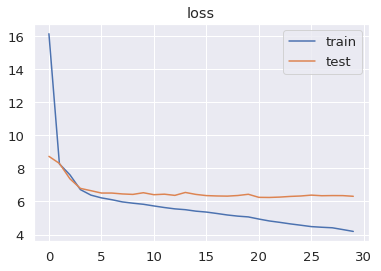

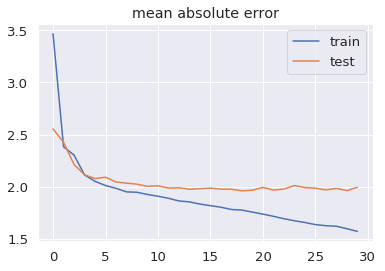

In [17]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.legend(["train","test"])
plt.title("loss")
plt.show()
plt.plot(hist.history["mean_absolute_error"])
plt.plot(hist.history["val_mean_absolute_error"])
plt.legend(["train","test"])
plt.title("mean absolute error")
plt.show()

**Expected Output (approximately):**

```
Train on 3500 samples, validate on 604 samples
Epoch 1/30
3500/3500 [==============================] - 3s 991us/step - loss: 17.7917 - mean_absolute_error: 3.6456 - val_loss: 8.9291 - val_mean_absolute_error: 2.6259
Epoch 2/30
3500/3500 [==============================] - 1s 308us/step - loss: 8.3288 - mean_absolute_error: 2.4174 - val_loss: 8.4183 - val_mean_absolute_error: 2.4193
Epoch 3/30
3500/3500 [==============================] - 1s 313us/step - loss: 7.7538 - mean_absolute_error: 2.3174 - val_loss: 7.3692 - val_mean_absolute_error: 2.2865

........

Epoch 28/30
3500/3500 [==============================] - 1s 295us/step - loss: 4.1380 - mean_absolute_error: 1.5699 - val_loss: 6.8988 - val_mean_absolute_error: 2.0348
Epoch 29/30
3500/3500 [==============================] - 1s 300us/step - loss: 4.0851 - mean_absolute_error: 1.5492 - val_loss: 6.9087 - val_mean_absolute_error: 2.0201
Epoch 30/30
3500/3500 [==============================] - 1s 296us/step - loss: 4.0451 - mean_absolute_error: 1.5426 - val_loss: 6.8554 - val_mean_absolute_error: 2.0641

```

### Question 1:  

Based on the output above, do you think the model is over or under-fitting?

Give an example of a "base-line model" that you could compare against. The model would use the same input as your sequential model.

Write your anser in the cell below:

As we can see the after epoch 5 the test error stays about the same, while the train error keeps on decreasing. If we train a litle longer the test loss increases again, therefore the model is overfitting on the training data.<br>
A possible baseline model would be a normal dense neural network or basically any other simple, easy, maybe state-of-the-art model we would like.

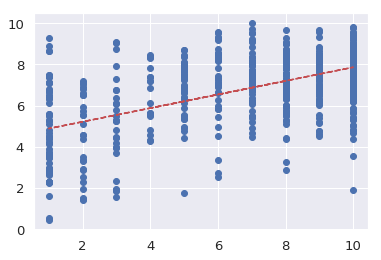

In [18]:
# we plot the predicted vs actual ratings on the validation set:
from matplotlib import pylab

x, y = test_ratings, preds[:,0]
pylab.plot(test_ratings,preds,'o')

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

_ = pylab.plot(x,p(x),"r--")

As mentioned in the introduction, the DrugReviews dataset contains another variable 'effectiveness', in which patients rated the effectiveness of the drug they were given.

They had to rate the effectiveness on a scale from "ineffective" to "highly effective":

In [19]:
drugreviews['effectiveness'].unique()

array(['considerably effective', 'highly effective',
       'moderately effective', 'marginally effective', 'ineffective'],
      dtype=object)

### Question 2:  

Name two ways in which you could encode the variable "effectiveness". Write them in the cell below.

One-hot encode it <br>
Or since there is an ordering to the values one could also transfer them to numbers 1 - 5 (with ineffective = 1 and considerably effective = 5)

## Task 3:

Now that you have gathered experience with Keras over the last tutorials, you will be given a Task to perform more freely than usual.

Train a model of your choice that predicts the effectiveness of a drug based on the review. This will require you to perform the following tasks:


1.   Numerically encode the variable "effectiveness" in a way that it can be used in a machine-learning setting
2.   Define a model architecture that takes the sequences of sentence embeddings computed above, and calculates the effectiveness. This may or may not be a sequential model. Try playing around!
3.   Define the appropriate loss function and train a model using the first 3500 observations in the dataset as the training set, and the remaining as the validation set (as we did above).

You can leave feedback and a small conclusion of this task in the Feedback field below. Was it easy or difficult? Where did you have problems?

In the collab notebook, it might be necessary to run your code as we did above:


```
with tf.Session() as session:
      K.set_session(session)
      # define the model
      # fit the model
      # evaluate the model
```



In [0]:
drugreviews['effectiveness']
# drugreviews['effectiveness_int'] = drugreviews.mask(drugreviews['effectiveness'] == 'considerably effective', 5)
drugreviews['effectiveness_num'] = drugreviews['effectiveness'].map( {'ineffective':1, 'marginally effective':2, 'moderately effective':3, 'considerably effective':4, 'highly effective':5})

In [0]:
from keras.utils import to_categorical

#define fixed order
categories = ['ineffective', 'marginally effective',
              'moderately effective',
              'considerably effective', 'highly effective']

vectors = {cat:np.array([1]*i + [0]*(len(categories)-i)) 
                for i,cat in enumerate(categories,1) }

index2lbl = {i:lbl for i,lbl in enumerate(categories,1) }

effectiveness_ord = np.array([vectors[x] for x in drugreviews['effectiveness']])

In [0]:
# everything that ends with _oh => uses one hot encoding
drugreviews_oh = drugreviews['effectiveness'].str.get_dummies()[categories]
#drugreviews = drugreviews.join(drugreviews_oh)

In [0]:
import keras.backend as K

# turn prediction back into int values & calculates new value for ordinal values
def mean_abs_error_ord(y_true, y_pred):
    actual = K.sum(y_true ,axis=1)
    pred   = K.sum(K.round(y_pred), axis=1)
    return K.mean(K.abs(actual-pred))
  
# turn prediction back into int values & calculates new value for ordinal values
def mean_abs_error_oh(y_true, y_pred):
    actual = K.argmax(y_true ,axis=1)
    pred   = K.argmax(y_pred, axis=1)
    return K.mean(K.abs(actual-pred))


In [0]:
effectiveness = np.array(drugreviews['effectiveness_num'])

train_effectiveness_oh = drugreviews_oh[0:3500]
test_effectiveness_oh = drugreviews_oh[3500:]

train_effectiveness = effectiveness[0:3500]
test_effectiveness = effectiveness[3500:]

train_effectiveness_ord = effectiveness_ord[0:3500]
test_effectiveness_ord = effectiveness_ord[3500:]

In [0]:
def get_model_oh():
    
    in_layer = Input(shape=(10,512))
    lstm_layer1 = LSTM(4)(in_layer)
    #lstm_layer2 = LSTM(4)(lstm_layer1)
    #dense = Dense(5, activation='sigmoid')(lstm_layer1)
    out_layer = Dense(5, activation='sigmoid')(lstm_layer1)
    
    model = Model(inputs=in_layer, outputs=out_layer)
    
    return model

In [26]:
with tf.Session() as session:
  
  K.set_session(session) 
  lstm_model_oh = get_model_oh() # (load the model)
  
  # (compile and fit)
  lstm_model_oh.compile(Adam(lr=0.01), loss='mean_squared_error', metrics=[mean_abs_error_oh])
  hist_oh = lstm_model_oh.fit(x=train_reviews, y=train_effectiveness_oh, epochs=30, verbose=1, validation_data=(test_reviews, test_effectiveness_oh))
  
  preds_oh = lstm_model_oh.predict(test_reviews)

Train on 3500 samples, validate on 604 samples
Epoch 1/30
3500/3500 [==============================] - 4s 1ms/step - loss: 0.1503 - mean_abs_error_oh: 0.7349 - val_loss: 0.1421 - val_mean_abs_error_oh: 0.7881
Epoch 2/30
3500/3500 [==============================] - 1s 327us/step - loss: 0.1405 - mean_abs_error_oh: 0.6983 - val_loss: 0.1409 - val_mean_abs_error_oh: 0.6291
Epoch 3/30
3500/3500 [==============================] - 1s 328us/step - loss: 0.1389 - mean_abs_error_oh: 0.4937 - val_loss: 0.1383 - val_mean_abs_error_oh: 0.6821
Epoch 4/30
3500/3500 [==============================] - 1s 331us/step - loss: 0.1371 - mean_abs_error_oh: 0.4297 - val_loss: 0.1376 - val_mean_abs_error_oh: 0.2119
Epoch 5/30
3500/3500 [==============================] - 1s 332us/step - loss: 0.1351 - mean_abs_error_oh: 0.3509 - val_loss: 0.1348 - val_mean_abs_error_oh: 0.4702
Epoch 6/30
3500/3500 [==============================] - 1s 331us/step - loss: 0.1334 - mean_abs_error_oh: 0.3840 - val_loss: 0.1332 - v

In [0]:
def get_model():
    
    in_layer = Input(shape=(10,512))
    lstm_layer1 = LSTM(4)(in_layer)
    #lstm_layer2 = LSTM(4)(lstm_layer1)
    #dense = Dense(5, activation='sigmoid')(lstm_layer1)
    out_layer = Dense(1, activation='sigmoid')(lstm_layer1)
    
    model = Model(inputs=in_layer, outputs=out_layer)
        
    return model

In [28]:
with tf.Session() as session:
  
  K.set_session(session) 
  lstm_model = get_model() # (load the model)
  
  # (compile and fit)
  lstm_model.compile(Adam(lr=0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])
  hist = lstm_model.fit(x=train_reviews, y=train_effectiveness, epochs=30, verbose=1, validation_data=(test_reviews, test_effectiveness))
  
  preds = lstm_model.predict(test_reviews)

Train on 3500 samples, validate on 604 samples
Epoch 1/30
3500/3500 [==============================] - 4s 1ms/step - loss: 10.2918 - mean_absolute_error: 2.9632 - val_loss: 9.9984 - val_mean_absolute_error: 2.9018
Epoch 2/30
3500/3500 [==============================] - 1s 339us/step - loss: 10.0536 - mean_absolute_error: 2.9236 - val_loss: 9.9846 - val_mean_absolute_error: 2.8994
Epoch 3/30
3500/3500 [==============================] - 1s 340us/step - loss: 10.0452 - mean_absolute_error: 2.9221 - val_loss: 9.9800 - val_mean_absolute_error: 2.8985
Epoch 4/30
3500/3500 [==============================] - 1s 333us/step - loss: 10.0420 - mean_absolute_error: 2.9215 - val_loss: 9.9778 - val_mean_absolute_error: 2.8981
Epoch 5/30
3500/3500 [==============================] - 1s 338us/step - loss: 10.0403 - mean_absolute_error: 2.9212 - val_loss: 9.9766 - val_mean_absolute_error: 2.8979
Epoch 6/30
3500/3500 [==============================] - 1s 338us/step - loss: 10.0393 - mean_absolute_error: 2

In [29]:
with tf.Session() as session:
  
  K.set_session(session) 
  lstm_model_ord = get_model_oh() # (load the model)
  
  # (compile and fit)
  lstm_model_ord.compile(Adam(lr=0.01), loss='mean_squared_error', metrics=[mean_abs_error_ord])
  hist_ord = lstm_model_ord.fit(x=train_reviews, y=train_effectiveness_ord, epochs=30, verbose=1, validation_data=(test_reviews, test_effectiveness_ord))
  
  preds_ord = lstm_model_ord.predict(test_reviews)

Train on 3500 samples, validate on 604 samples
Epoch 1/30
3500/3500 [==============================] - 4s 1ms/step - loss: 0.1441 - mean_abs_error_ord: 0.9714 - val_loss: 0.1203 - val_mean_abs_error_ord: 0.9073
Epoch 2/30
3500/3500 [==============================] - 1s 318us/step - loss: 0.1143 - mean_abs_error_ord: 0.8637 - val_loss: 0.1116 - val_mean_abs_error_ord: 0.8179
Epoch 3/30
3500/3500 [==============================] - 1s 315us/step - loss: 0.1086 - mean_abs_error_ord: 0.7971 - val_loss: 0.1083 - val_mean_abs_error_ord: 0.7864
Epoch 4/30
3500/3500 [==============================] - 1s 319us/step - loss: 0.1053 - mean_abs_error_ord: 0.7660 - val_loss: 0.1046 - val_mean_abs_error_ord: 0.7566
Epoch 5/30
3500/3500 [==============================] - 1s 315us/step - loss: 0.1030 - mean_abs_error_ord: 0.7469 - val_loss: 0.1090 - val_mean_abs_error_ord: 0.7798
Epoch 6/30
3500/3500 [==============================] - 1s 307us/step - loss: 0.1017 - mean_abs_error_ord: 0.7303 - val_loss:

Text(0.5, 1.0, 'mean absolute error ordinal')

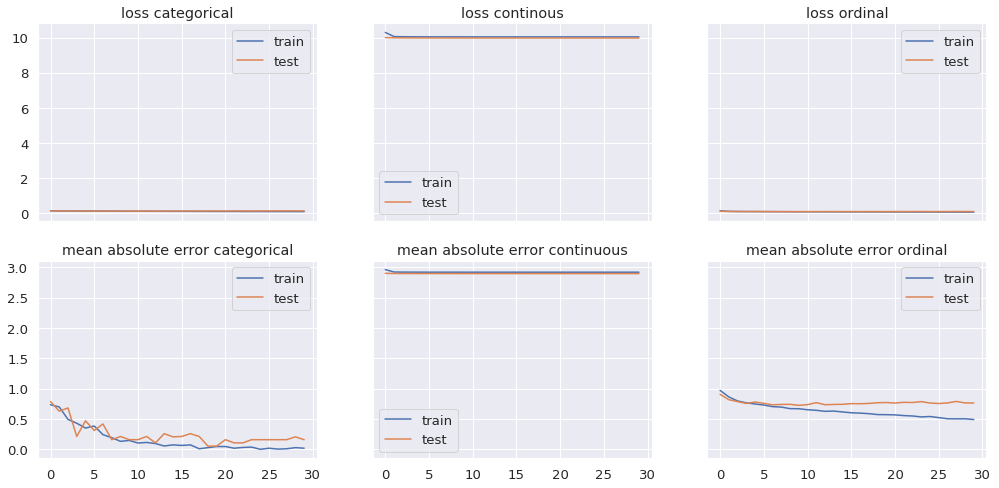

In [30]:
fig, axs = plt.subplots(2,3, figsize=(17.0, 8.0), sharey='row', sharex=True)
axs[0, 0].plot(hist_oh.history["loss"])
axs[0, 0].plot(hist_oh.history["val_loss"])
axs[0, 0].legend(["train","test"])
axs[0, 0].set_title("loss categorical")
#plt.show()
axs[1, 0].plot(hist_oh.history["mean_abs_error_oh"])
axs[1, 0].plot(hist_oh.history["val_mean_abs_error_oh"])
axs[1, 0].legend(["train","test"])
axs[1, 0].set_title("mean absolute error categorical")

axs[0, 1].plot(hist.history["loss"])
axs[0, 1].plot(hist.history["val_loss"])
axs[0, 1].legend(["train","test"])
axs[0, 1].set_title("loss continous")
# plt.show()
axs[1, 1].plot(hist.history["mean_absolute_error"])
axs[1, 1].plot(hist.history["val_mean_absolute_error"])
axs[1, 1].legend(["train","test"])
axs[1, 1].set_title("mean absolute error continuous")

axs[0, 2].plot(hist_ord.history["loss"])
axs[0, 2].plot(hist_ord.history["val_loss"])
axs[0, 2].legend(["train","test"])
axs[0, 2].set_title("loss ordinal")
# plt.show()
#axs[1, 2].plot(hist_ord.history["mean_absolute_error"])
#axs[1, 2].plot(hist_ord.history["val_mean_absolute_error"])
axs[1, 2].plot(hist_ord.history["mean_abs_error_ord"])
axs[1, 2].plot(hist_ord.history["val_mean_abs_error_ord"])
axs[1, 2].legend(["train","test"])
axs[1, 2].set_title("mean absolute error ordinal")
# axs[0].title("With one-hot encoding")
#plt.show()

Text(0.5, 1.0, 'mean absolute error ordinal')

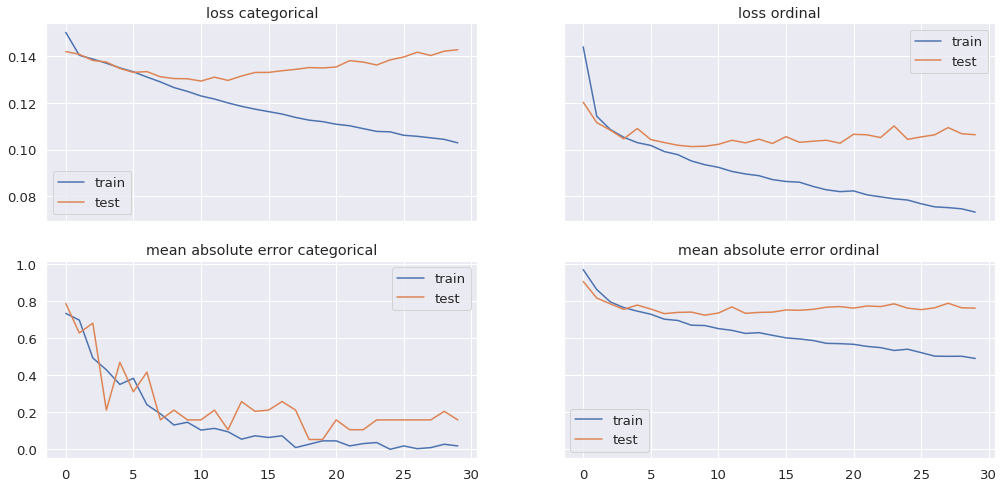

In [31]:
fig, axs = plt.subplots(2,2, figsize=(17.0, 8.0), sharey='row', sharex=True)
axs[0, 0].plot(hist_oh.history["loss"])
axs[0, 0].plot(hist_oh.history["val_loss"])
axs[0, 0].legend(["train","test"])
axs[0, 0].set_title("loss categorical")
#plt.show()
axs[1, 0].plot(hist_oh.history["mean_abs_error_oh"])
axs[1, 0].plot(hist_oh.history["val_mean_abs_error_oh"])
axs[1, 0].legend(["train","test"])
axs[1, 0].set_title("mean absolute error categorical")

axs[0, 1].plot(hist_ord.history["loss"])
axs[0, 1].plot(hist_ord.history["val_loss"])
axs[0, 1].legend(["train","test"])
axs[0, 1].set_title("loss ordinal")
# plt.show()
#axs[1, 2].plot(hist_ord.history["mean_absolute_error"])
#axs[1, 2].plot(hist_ord.history["val_mean_absolute_error"])
axs[1, 1].plot(hist_ord.history["mean_abs_error_ord"])
axs[1, 1].plot(hist_ord.history["val_mean_abs_error_ord"])
axs[1, 1].legend(["train","test"])
axs[1, 1].set_title("mean absolute error ordinal")
# axs[0].title("With one-hot encoding")
#plt.show()

In [0]:
from IPython.display import HTML
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

def confusion(predicted, actual, title_m, n = 5):
    confusion = np.zeros((n, n))

    for a,p in zip(actual,predicted):
        confusion[int(a),int(p)] +=1
    
    # Set colormap equal to seaborns light green color palette
    cm = sns.light_palette("green", as_cmap=True)
    # df = pd.DataFrame(confusion, rownames=['Actual'], colnames=['Predicted'])
    df = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    #df = (df.style
    #  .background_gradient(cmap=cm)
      #.highlight_max(subset=['total_amt_usd_diff','total_amt_usd_pct_diff'])
      #.set_caption('This is a custom caption.')
    #  .format("{:.0f}")
      #.set_table_styles(styles)
    #)
    sns.heatmap(df, annot=True, fmt='.0f', cmap=cm)
    plt.title(title_m)
    # display(df)


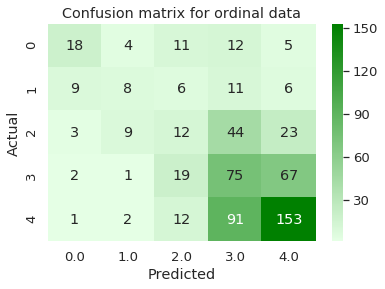

In [33]:
actual_ord = np.sum(test_effectiveness_ord ,axis=1) - 1
preds_ord_2 = np.sum(np.rint(preds_ord), axis=1) - 1
confusion(preds_ord_2, actual_ord, "Confusion matrix for ordinal data") # 230

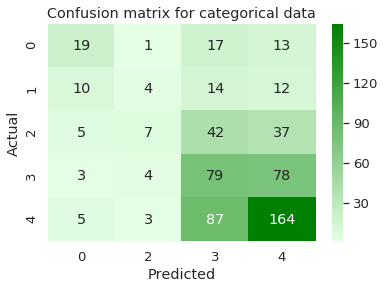

In [34]:
actual_oh = np.argmax(np.array(test_effectiveness_oh) ,axis=1)
preds_oh_2   = np.argmax(preds_oh, axis=1)
confusion(preds_oh_2, actual_oh, "Confusion matrix for categorical data") # 286

## Feedback:

For **Task 3** write your conclusions and feedback in the cell below

Our conclusion: The data should either be treated as categorical (one hot-encoding without ordering => only the category it is is 1) or ordinal (one-hot-encoding with ordering => the category itself and all lower categories are 1). Both give good results, categorical gives slightly better results, although it overfits faster and the results with ordinal data are more stable.
The confusion matrices show, that categorical data has a higher accuracy than ordinal (286 on main diagonal vs. 230). But the ordinal data shows lower variance in the confusion matrix again.

Treating the data as continous is a bad idea, the mean absolute error is at 3, which is not surprising considering that the network always predicts a value around 1, if you show the predictions.
